In [1]:
import json
import os.path as osp
import sys
from types import SimpleNamespace

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import pair_confusion_matrix
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from models.model_factory import model_generator


def pil_loader(path, type):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert(type)


df_parts = np.array([[0, 0, 0],
                     [0, 100, 0],
                     [16, 78, 139],
                     [50, 205, 50],
                     [70, 130, 180],
                     [127, 255, 212],
                     [144, 238, 144],
                     [211, 211, 211],
                     [220, 220, 220],
                     [245, 222, 179],
                     [250, 235, 215],
                     [255, 0, 0],
                     [255, 140, 0],
                     [255, 250, 205],
                     [255, 250, 250],
                     [255, 255, 0]], dtype=int)


def adjusted_rand_score_overflow(labels_true, labels_pred):
    (tn, fp), (fn, tp) = pair_confusion_matrix(labels_true, labels_pred)

    # Special cases: empty data or full agreement
    if fn == 0 and fp == 0:
        return 1.0
    (tn, fp), (fn, tp) = (tn / 1e8, fp / 1e8), (fn / 1e8, tp / 1e8)
    return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
                                       (tp + fp) * (fp + tn))

class DF(Dataset):
    def __init__(self, split, root='/tmp/datasets', transforms=None):
        super().__init__()

        self.root = root
        self.split = split
        self.transforms = transforms

        self.image_dir = osp.join(self.root, 'DeepFashion/In-shop Clothes Retrieval Benchmark/')

        if self.split == 'train':
            self.files = self.only_file_names(json.load(open(f'{self.image_dir}/Anno/segmentation/DeepFashion_segmentation_train.json', 'r'))['images'])
        elif self.split == 'test':
            val_files = [f'{self.image_dir}/Anno/segmentation/{f}' for f in ['DeepFashion_segmentation_query.json', 'DeepFashion_segmentation_gallery.json']]
            self.files = self.only_file_names(json.load(open(val_files[0], 'r'))['images']) + self.only_file_names(json.load(open(val_files[1], 'r'))['images'])
        else:
            raise ValueError("Invalid split name: {}".format(self.split))
        self.num_imgs = len(self.files)
        print('%d images' % self.num_imgs)

        sum_colors = df_parts.sum(1)
        self.col2idx = -np.ones(sum_colors.max() + 1, dtype=np.uint8)
        for i in range(sum_colors.shape[0]):
            self.col2idx[sum_colors[i]] = i

    @staticmethod
    def only_file_names(lst):
        return [e['file_name'] for e in lst]

    def __getitem__(self, index):
        path = self.files[index]
        image = pil_loader(self.image_dir + '/Anno/segmentation/' + path, 'RGB')
        seg = pil_loader(self.image_dir + '/Anno/segmentation/' + path.replace('.jpg', '_segment.png'), 'RGB')
        seg = np.array(seg).astype(np.uint8)
        seg = self.col2idx[seg.sum(2)]
        assert -1 not in seg

        mask = np.array(pil_loader(self.image_dir + '/supervisedlabels/' + path + '.png', 'L'))
        image = self.transforms[0](image)
        seg = self.transforms[1](Image.fromarray(seg))
        mask = self.transforms[1](Image.fromarray(mask))
        return {'path': path, 'image': image, 'mask': mask, 'seg': seg}

    def __len__(self):
        return len(self.files)




class To_tensor():
    def __call__(self, img):
        img = np.array(img, np.float32, copy=False)
        if len(img.shape) == 2:
            img = np.expand_dims(img, 2)
        img = torch.from_numpy(img)
        img = img.permute((2, 0, 1)).contiguous()
        return img

from datasets import deepfashion
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets.lit_dataset import LitDataset
def get_fg_nmi_ari(path, is_scops, num_parts=4, mask_type='sup_mask'):
    opts = SimpleNamespace()
    opts.input_size = 256
    opts.split = 'test'
    opts.unsup_mask = mask_type
    opts.unsup_mask2 = False
    opts.unsup_train = False
    opts.model = "DeepLab50_2branch"
    opts.dataset_root = '/work/subha/datasets/'
    opts.single_class = None
    opts.three_classes = None
    opts.restore_from = 'None'
    opts.num_parts = num_parts
    opts.gpu = 0
    test_dataset = deepfashion.DFDataset(opts)
    test_loader = DataLoader(LitDataset(test_dataset), batch_size=8, shuffle=False, num_workers=5, drop_last=False)
    interp = nn.Upsample(size=(opts.input_size, opts.input_size), mode='bilinear', align_corners=True)
    model = model_generator(opts, add_bg_mask=is_scops)
    model.load_state_dict(torch.load(path) if is_scops else torch.load(path)['model_state_dict'])
    model.cuda()
    model.eval()
 
    gts = []
    preds = []
    for batch in tqdm(test_loader):
        images_cpu = batch['img']
        gt = batch['seg']
        images = images_cpu.cuda(opts.gpu)
        _, _, pred_low, _ = model(images)
        pred = interp(pred_low)

        pred_argmax = pred.argmax(dim=1)
        gts.append(gt.type(torch.int8))
        preds.append(pred_argmax.cpu().type(torch.int8))

    gts = torch.cat(gts, 0).flatten()
    preds = torch.cat(preds, 0).flatten()

    preds = preds[gts != 0]
    gts = gts[gts != 0]

    fgari = adjusted_rand_score_overflow(preds, gts)*100
    fgnmi = normalized_mutual_info_score(preds, gts)*100
    return fgnmi, fgari

def get_full_nmi_ari(data_loader, model, is_scops, gpu=0):
    all_nmi_preds = []
    all_nmi_preds_w_bg = []
    all_nmi_gts = []
    all_nmi_gts_w_bg = []

    # iterating the data loader, landmarks shape: [N, num_landmarks, 4], column first
    # bbox shape: [N, 5]
    for i, batch in enumerate(tqdm(data_loader)):

        with torch.no_grad():

            seg = batch['seg']
            fg_mask = batch['mask'].cuda(gpu)
            images = batch['image'].cuda(gpu)
            if is_scops:
                # preprocessing from scops evaluation code
                logit_w_bg = F.interpolate(model(images)[2], size=images.shape[-2:], mode='bilinear', align_corners=False)
                logit_w_bg = torch.softmax(logit_w_bg, dim=1)
                logit_w_bg /= logit_w_bg.max(dim=3, keepdim=True)[0].max(dim=2, keepdim=True)[0]
                logit_w_bg[:,0,:,:] = 0.1
                pred = logit_w_bg[:,1:].argmax(1, keepdim=True)
                pred_w_bg = logit_w_bg.argmax(1, keepdim=True)
            else:
                pred = F.interpolate(model(images)[2], size=images.shape[-2:], mode='bilinear', align_corners=False).argmax(1, keepdim=True)
                pred_w_bg = fg_mask * (pred + 1)
                if i == 0:
                    # print(seg.shape, pred.shape, pred_w_bg.shape)
                    plt.imshow(seg.cpu().numpy().squeeze()*50)
                    plt.show()
                    plt.imshow(pred.cpu().numpy().squeeze()*50)
                    plt.show()
                    plt.imshow(pred_w_bg.cpu().numpy().squeeze()*50)
                    plt.show()
                    plt.imshow(fg_mask.cpu().numpy().squeeze())
                    plt.show()


            all_nmi_preds_w_bg.append(pred_w_bg.cpu().view(-1).numpy())
            all_nmi_gts_w_bg.append(seg.type(torch.int8).cpu().view(-1).numpy())

    all_nmi_preds_w_bg = np.concatenate(all_nmi_preds_w_bg, axis=0)
    all_nmi_gts_w_bg = np.concatenate(all_nmi_gts_w_bg, axis=0)

    nmi2 = normalized_mutual_info_score(all_nmi_gts_w_bg, all_nmi_preds_w_bg) * 100
    ari2 = adjusted_rand_score_overflow(all_nmi_gts_w_bg, all_nmi_preds_w_bg) * 100
    return nmi2, ari2


def eval_df(path=None, is_scops=False, num_parts=4, req_label=1, image_size=256):
    # define data transformation (no crop)
    data_transforms = [transforms.Compose([
        transforms.Resize(size=(image_size)),
        To_tensor(),
        transforms.Normalize(mean=(104.00698793, 116.66876762, 122.67891434), std=(1, 1, 1))
    ]),
        transforms.Compose([
            transforms.Resize(size=(image_size)),
            To_tensor()
        ])]

    # define dataset and loader
    data = DF(split='test', transforms=data_transforms, root='../data')
    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)
    args2 = SimpleNamespace(dataset_root='/work/subha/datasets/', use_lab=True, single_class=None,
                            gpu=0, batch_size=6, input_size=image_size, split='test', model="DeepLab50_2branch",
                            num_parts=num_parts, num_classes=15, restore_from='None', unsup_mask=True)

    model = model_generator(args2, add_bg_mask=is_scops)
    model.load_state_dict(torch.load(path) if is_scops else torch.load(path)['model_state_dict'])
    model.cuda()
    model.eval()

    full_nmi, full_ari = get_full_nmi_ari(loader, model, is_scops=is_scops)
    fg_nmi, fg_ari = get_fg_nmi_ari(path, is_scops, num_parts=4, mask_type='sup')
    return fg_nmi, fg_ari, full_nmi, full_ari


6922 images


  0%|                                                                                                                                                                                | 0/6922 [00:00<?, ?it/s]

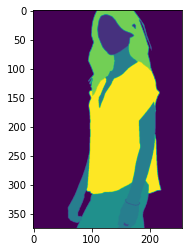

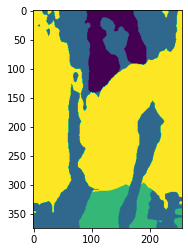

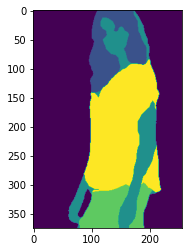

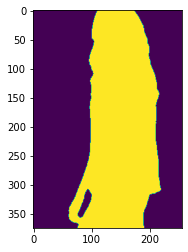

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6922/6922 [14:26<00:00,  7.99it/s]


6922 images


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 866/866 [02:51<00:00,  5.06it/s]


FG-NMI: 44.54 FG-ARI: 46.20 Full-NMI: 68.10 Full-ARI: 90.60


In [2]:
is_scops = False
path = '../checkpoints/DeepFashion/model_100000.pth'
fg_nmi, fg_ari, full_nmi, full_ari = eval_df(path=path, is_scops=is_scops)
print(f'FG-NMI: {fg_nmi:2.2f} FG-ARI: {fg_ari:2.2f} Full-NMI: {full_nmi:2.2f} Full-ARI: {full_ari:2.2f}')